In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
all_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [75]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek_alt={0:'Monday', 1:'TuesFri', 2:'TuesFri', 3:'TuesFri', 4:'TuesFri', 5:'SatSun', 6:'SatSun'}
MonthName={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'} 
MonthName_alt={1:'JanFeb', 2:'JanFeb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'SepNov',10:'SepNov',11:'SepNov',12:'Dec'}
timeOfDay = {5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Afternoon',
        12: 'Afternoon', 13: 'Afternoon', 14: 'Afternoon', 15: 'Afternoon', 16: 'Night', 17: 'Night', 18: 'Night',
        19: 'Night', 20: 'Night', 21: 'Night', 22: 'Night', 23: 'Night', 0: 'Midnight',}

def process_data(df):
    df.ix[pd.isnull(df['Name']), 'Named'] = 'Unnamed'
    df.ix[pd.isnull(df['Named']), 'Named'] = 'Named'
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['weekday'] = df['DateTime'].dt.dayofweek.map(dayOfWeek_alt)
    df['month'] = df['DateTime'].dt.month.map(MonthName_alt)
    df['hour'] = df['DateTime'].dt.hour

    
    df.loc[:,('corp')] = df.Color + ' ' + df.Breed + ' ' + \
                        df.SexuponOutcome + ' ' + df.Named + \
                        ' ' + df.weekday + ' ' + df.month

    return df

all_train = process_data(all_train)



cv = CountVectorizer(min_df=0.05)
train_corpus = cv.fit_transform(all_train.corp)

def add_dog_type(corpus, df, training=True):
    dense_corpus = pd.DataFrame(corpus.toarray(), columns = cv.get_feature_names())

    add = pd.concat([(all_train.AnimalType == 'Dog').astype(int), 
                     pd.get_dummies(all_train.hour),
                    pd.get_dummies(all_train.AgeuponOutcome)], axis=1)
    
    if training:
        add = pd.concat([add, all_train.OutcomeType], axis=1)
    return pd.concat([dense_corpus, add], axis=1)

new_corp = add_dog_type(train_corpus, all_train)

split = new_corp.shape[0] // 20
dev = new_corp.iloc[:split,:-1]
train = new_corp.iloc[split:,:-1]

dev_labels = new_corp.iloc[:split,-1]
train_labels = new_corp.iloc[split:,-1]



In [77]:
new_corp.columns

Index([        u'apr',         u'aug',       u'black',        u'blue',
             u'brown',        u'bull',   u'chihuahua',         u'dec',
          u'domestic',      u'female',
       ...
            u'6 days',    u'6 months',     u'6 years',    u'7 months',
           u'7 years',    u'8 months',     u'8 years',    u'9 months',
           u'9 years', u'OutcomeType'],
      dtype='object', length=102)

Logistic Regression Log Loss: 0.829
Logistic Regression Accuracy: 0.656
RF Log Loss: 1.003
RF Accuracy: 0.650


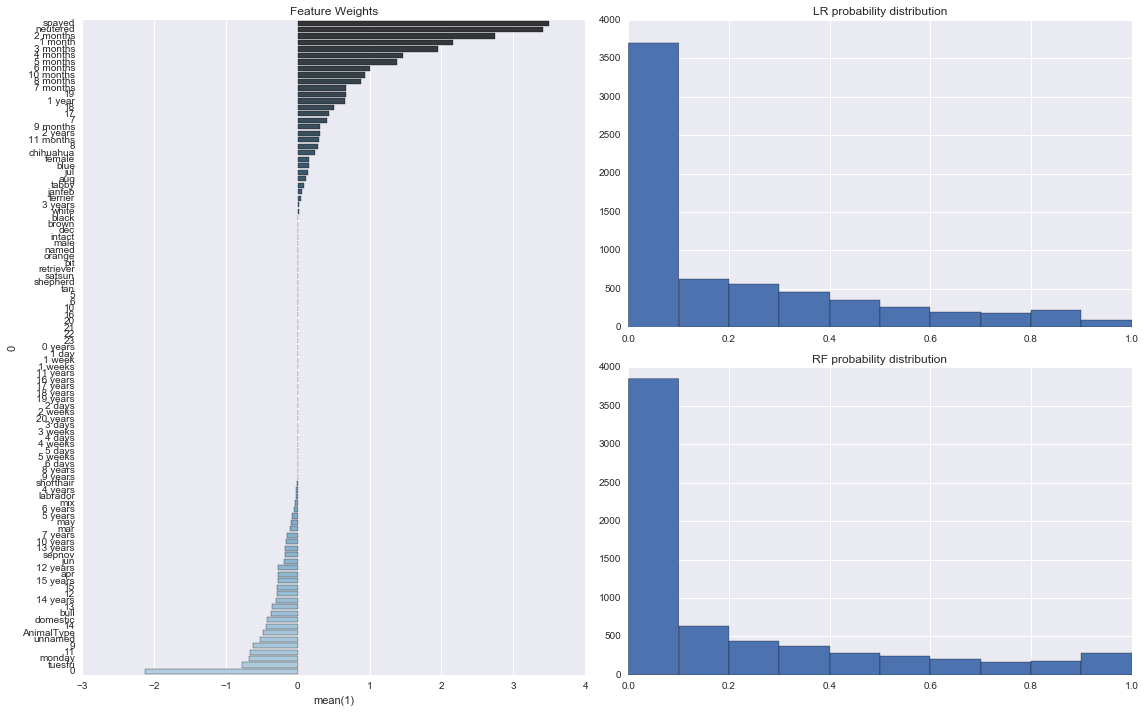

In [79]:
clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(train, train_labels)
preds = clf.predict_proba(dev)
print 'Logistic Regression Log Loss: {:.3f}'.format(log_loss(dev_labels, preds))
print 'Logistic Regression Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

feat_import = sorted(zip(train.columns, clf.coef_[0]), 
                     key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(16,10)) 
plt.subplot(1,2,1)
sns.barplot(pd.DataFrame(feat_import)[1], pd.DataFrame(feat_import)[0], orient="h", palette='Blues_d')
plt.title('Feature Weights')

plt.subplot(2,2,2)
plt.hist(preds.ravel(), range=[0,1])
plt.title('LR probability distribution')

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf.fit(train, train_labels)
preds = clf.predict_proba(dev)
print 'RF Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
print 'RF Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

plt.subplot(2,2,4)
plt.hist(preds.ravel(), range=[0,1])
plt.title('RF probability distribution')

plt.tight_layout()

In [17]:
clf.fit(new_corp.iloc[:,:-1], new_corp.iloc[:,-1])

test = process_data(test)
test_corpus = cv.transform(test.corp)

new_test = add_dog_type(test_corpus, test, training=False)

preds = clf.predict_proba(new_test)


for i, outcome in enumerate(clf.classes_):
    test[outcome] = preds[:,i]

In [18]:
submission = test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]
submission.to_csv('submission.csv', index=False)